### Závěrečný projekt - modul Python

V tomto projektu budete analyzovat data ze stránky `www.sreality.cz`. Budete tedy získávat aktuální nabídku bytů ve Zlíně.
Projekt se dělí na 2 části:
1. WebScraping - pomocí knihovny `BeautifulSoup` získejte všechny aktuální inzerce bytů v daném městě. 
- Získáte **tyto** informace: `URL odkaz bytu, rozměry bytu, dispozice bytu, cena bytu, lokace bytu (Ulice+město)`
2. Datová analýza - ETL proces
- V první fázi prověďte processing dat tak, aby obsahovala příslušné datové typy, nenulové hodnoty atp. Ulice i město bude v samostatných sloupcích.
- Zprocesovaná a vyčištěná data vyexportujte do `.csv` souboru s názvem `{vašeJméno}_zdrojová_data.csv`
3. Datová analýza - analýza dat
- Třetí část začněte tak, že si do dataframe nahrajete vámi vyexportovaný `.csv` soubor s vyscrapovanými daty.
- Ve druhé fázi proveďte analýzu dat a odpovězte na tyto dotazy:
- `Jaká je průměrná cena bytů?`
- `Jaká je průměrná cena bytů pro každou dispozice (1+1, 2+1, atp.)? Zobrazte i na grafu.`
- `Jaká je průměrná velikost bytu pro každou dispozice?`
- `Existuje ulice, kde je vyšší koncentrace dražších bytů?`
- `Jaký typ dispozice je v daném městě nejčastěji inzerovan? Který to je? Proč myslíte, že tomu tak je?`
- `Existují zde inzerce bytů, které stojí více, než 20.000,-? Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`
- `Zjištěte minimální a maximální inzerce pro každou dispozici bytu. Která dispozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?`


Dotazy zodpovězte ve vašem pracovním notebooku a výsledný soubor nahrajte na GitHub.


### WebScraping

In [145]:
from bs4 import BeautifulSoup
import requests
import pprint


headers = {
    "User-Agent": "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"
}
response = requests.get(url, headers=headers)

list_nabidek = []
navstivene_odkazy = set()
strana = 1

while True:
    url = f'https://www.sreality.cz/hledani/pronajem/byty/zlin?strana={strana}'
    response = requests.get(url)

    print(url)
    print('----------------------')

    soup = BeautifulSoup(response.text, "html.parser")
    vsechny_nabidky = soup.find_all(name='li', class_='MuiGrid2-root')

    for nabidka in vsechny_nabidky:
        cast_odkazu = nabidka.find('a', class_='MuiTypography-root')
        if not cast_odkazu:
            continue  # pokud není odkaz, přeskoč

        plny_odkaz = 'https://www.sreality.cz' + cast_odkazu['href']

        if plny_odkaz in navstivene_odkazy:
            continue  # přeskoč duplicitu
        navstivene_odkazy.add(plny_odkaz)

        # Načti detail inzerátu
        response = requests.get(plny_odkaz)
        soup_detail = BeautifulSoup(response.text, 'html.parser')

        # Získání ceny
        cena_element = soup_detail.find('p', class_='MuiTypography-root')
        if cena_element:
            cena = cena_element.text.strip()
        else:
            cena = 'Cena na vyžádání'

        # Získání názvu
        nazev_element = soup_detail.find(name='h1', class_='css-h2bhwn')
        if nazev_element:
            nazev = nazev_element.text.strip()
        else:
            nazev = 'Neznámý název'

        objekt = {
            'Název': nazev,
            'Cena': cena,
            'URL': plny_odkaz
        }

        list_nabidek.append(objekt)

    print('Hledám další STRÁNKU...')

    # Najdi tlačítko "Další stránka"
    tlacitka = soup.find_all(name='div', class_='css-1wzyqky')
    tlacitko_dalsi = False

    for tlacitko in tlacitka:
        if tlacitko.text == 'Další stránka':
            tlacitko_dalsi = True

    if tlacitko_dalsi:
        strana += 1
        print(f"Zpracovávám stránku {strana}...")
    else:
        print("Další STRÁNKA nenalezena, konec...")
        break
    

https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=1
----------------------
Hledám další STRÁNKU...
Zpracovávám stránku 2...
https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=2
----------------------
Hledám další STRÁNKU...
Zpracovávám stránku 3...
https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=3
----------------------
Hledám další STRÁNKU...
Zpracovávám stránku 4...
https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=4
----------------------
Hledám další STRÁNKU...
Zpracovávám stránku 5...
https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=5
----------------------
Hledám další STRÁNKU...
Zpracovávám stránku 6...
https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=6
----------------------
Hledám další STRÁNKU...
Zpracovávám stránku 7...
https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=7
----------------------
Hledám další STRÁNKU...
Zpracovávám stránku 8...
https://www.sreality.cz/hledani/pronajem/byty/zlin?strana=8
----------------

### Datová analýza

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(list_nabidek)

# Odstranění záznamů, které mají v URL slovo "explicit"
df = df[~df['URL'].str.contains('explicit', case=False)]

#Očista ceny
df['Cena_cista'] = (
    df['Cena']
    .str.replace(r'[^\d,]', '', regex=True)  # odstraní vše kromě číslic a čárky
    .str.replace(r'\s+', '', regex=True)  # odstraní mezery mezi číslicemi
    .replace('', pd.NA)  # prázdné hodnoty na NaN
    .pipe(pd.to_numeric, errors='coerce')  # převede na číslo, nečíselné na NaN
)

# Vytažení dispozice a m²
df['Dispozice'] = df['Název'].str.extract(r'bytu\s+([\d\+\-kk]+)', expand=False)
df['Plocha_m2'] = df['Název'].str.extract(r'(\d+)\s*m²', expand=False).astype(float)

# Lokalita je zbytek za m² – odstraníme úvod, dispozici a m²
df['Lokalita'] = (
    df['Název']
    .str.extract(r'\d+\s*m²\s*(.*)', expand=False)  # zachytí vše po "m²"
    .str.strip()
)

#Uložení do CSV
df.to_csv('holubik_zdrojova_data.csv', index=False, sep=';', encoding='utf-8')




1  - Jaká je průměrná cena bytů?
Průměrná cena bytů: 13489 Kč/měsíc

2. - Jaká je průměrná cena bytů pro každou dispozice (1+1, 2+1, atp.)? Zobrazte i na grafu.
Průměrná cena bytů podle dispozice:
1+1     10 675 Kč
1+kk    11 466 Kč
2+1     12 932 Kč
2+kk    15 252 Kč
3+1     16 433 Kč
3+kk    17 359 Kč
4+1     22 350 Kč
4+kk    34 967 Kč


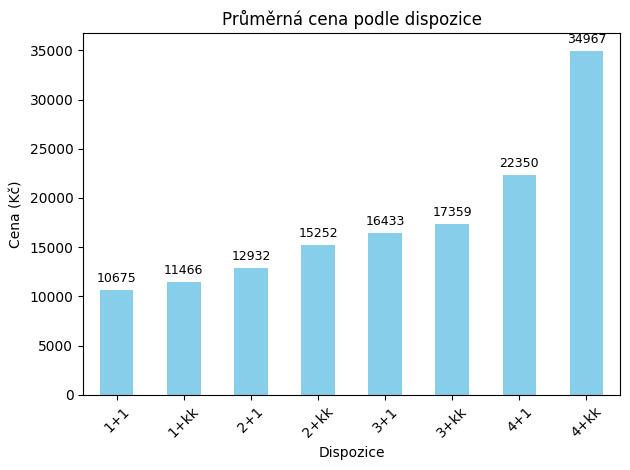



3. - Jaká je průměrná velikost bytu podle dispozice?
Dispozice
1+kk     30.660377
1+1      35.173913
2+kk     50.800000
2+1      57.948718
3+kk     70.277778
3+1      71.809524
4+1      84.500000
4+kk    120.000000
Name: Plocha_m2, dtype: float64


4. - Existuje ulice, kde je vyšší koncentrace dražších bytů?
Top 10 nejdražších lokalit:
Luhačovice                         39 900 Kč
Dr. Veselého  Luhačovice           36 000 Kč
Vrchy  Zlín - Kudlov               35 000 Kč
Havlíčkovo nábřeží  Zlín           30 000 Kč
Okružní  Zlín                      25 500 Kč
Partyzánská  Zlín                  23 500 Kč
Zálešná II  Zlín                   20 400 Kč
Úprkova  Luhačovice                20 000 Kč
Nebeská  Zlín - Příluky            19 800 Kč
Svobodova  Otrokovice              19 500 Kč


5. - Jaký typ dispozice je nejčastěji inzerován?
Dispozice
1+kk    53
2+1     39
2+kk    25
1+1     23
3+1     21
3+kk    18
4+1      4
4+kk     3
Name: count, dtype: int64
Nejčastěji inzerovaná dispozice: 1+

/var/folders/qd/0mbd93zs3z536nql79jsflgc0000gn/T/ipykernel_57972/1293053699.py:110: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(cenovy_rozptyl.applymap(format_kc).sort_values(by='Rozptyl', ascending=False))


,Název,Cena,URL,Cena_cista,Dispozice,Plocha_m2,Lokalita
0,"Pronájem bytu 1+kk 26 m²Lorencova, Zlín",1​0​ ​9​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/1+...,10900.0,1+kk,26.0,"Lorencova, Zlín"
1,"Pronájem bytu 1+kk 31 m²J. A. Bati, Zlín",C​e​n​a​ ​n​a​ ​v​y​ž​á​d​á​n​í​,https://www.sreality.cz/detail/pronajem/byt/1+...,NaN,1+kk,31.0,"J. A. Bati, Zlín"
2,"Pronájem bytu 1+kk 37 m²Zelinova, Zlín",1​1​ ​5​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/1+...,11500.0,1+kk,37.0,"Zelinova, Zlín"
3,"Pronájem bytu 1+kk 44 m²Osvobození, Slavičín",1​1​ ​0​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/1+...,11000.0,1+kk,44.0,"Osvobození, Slavičín"
4,"Pronájem bytu 1+kk 30 m²Podlesí II, Zlín",1​0​ ​0​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/1+...,10000.0,1+kk,30.0,"Podlesí II, Zlín"
5,"Pronájem bytu 1+kk 38 m²Pod Křiby, Zlín",1​1​ ​0​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/1+...,11000.0,1+kk,38.0,"Pod Křiby, Zlín"
6,"Pronájem bytu 1+kk 30 m²Leoše Janáčka, Luhačovice",1​0​ ​0​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/1+...,10000.0,1+kk,30.0,"Leoše Janáčka, Luhačovice"
7,"Pronájem bytu 1+1 38 m²Dřevnická, Zlín",9​ ​4​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/1+...,9400.0,1+1,38.0,"Dřevnická, Zlín"
8,"Pronájem bytu 2+1 44 m²Podlesí III, Zlín",1​5​ ​0​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/2+...,15000.0,2+1,44.0,"Podlesí III, Zlín"
9,Pronájem bytu 3+1 65 m²Zlín - Malenovice,1​8​ ​0​0​0​ ​K​č​/​m​ě​s​í​c​,https://www.sreality.cz/detail/pronajem/byt/3+...,18000.0,3+1,65.0,Zlín - Malenovice


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('holubik_zdrojova_data.csv', sep=";")




### 1. PRŮMĚRNÁ CENA
print('1  - Jaká je průměrná cena bytů?')
prumerna_cena = df['Cena_cista'].mean()
print(f"Průměrná cena bytů: {prumerna_cena:.0f} Kč/měsíc\n")


### 2. průmerná cena podle dispozice
print('2. - Jaká je průměrná cena bytů pro každou dispozice (1+1, 2+1, atp.)? Zobrazte i na grafu.')
prum_cena_podle_dispozice = (
    df.groupby('Dispozice')['Cena_cista']
    .mean()
    .round(0)  # zaokrouhlí na celé Kč
    .sort_values()
    .astype(int)
)
print("Průměrná cena bytů podle dispozice:")
# Formátovaný výpis s mezerami a Kč
for dispo, cena in prum_cena_podle_dispozice.items():
    print(f'{dispo:<6} {cena:>7,} Kč'.replace(',', ' '))

# Graf
# Vykreslení grafu
ax = prum_cena_podle_dispozice.plot(
    kind='bar',
    title='Průměrná cena podle dispozice',
    ylabel='Cena (Kč)',
    color='skyblue'
)

# Přidání hodnot nad sloupce
for i, hodnota in enumerate(prum_cena_podle_dispozice):
    ax.text(i, hodnota + 500, f'{hodnota}', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n')

###### 3. Jaká je průměrná velikost bytu podle dispozice?
print('3. - Jaká je průměrná velikost bytu podle dispozice?')

prum_velikost_podle_dispozice = df.groupby('Dispozice')['Plocha_m2'].mean().sort_values()
print(prum_velikost_podle_dispozice)
print('\n')



### 4. Existuje ulice, kde je vyšší koncentrace dražších bytů?
print('4. - Existuje ulice, kde je vyšší koncentrace dražších bytů?')
lokality_drahe = (
    df.dropna(subset=['Cena_cista'])  # Odstraní řádky s NaN v 'Cena_cista'
    .groupby('Lokalita')['Cena_cista']
    .mean()
    .sort_values(ascending=False)
    .astype(int)
    .round(0)
)

# Výpis top 10 nejdražších lokalit
print("Top 10 nejdražších lokalit:")
for lokalita, cena in lokality_drahe.head(10).items():
    print(f'{lokalita:<30} {cena:>10,} Kč'.replace(',', ' '))

print('\n')    

##### 5. Jaký typ dispozice je nejčastěji inzerován?
print('5. - Jaký typ dispozice je nejčastěji inzerován?')
nejcastejsi_dispozice = df['Dispozice'].value_counts()
print(nejcastejsi_dispozice)

nejbeznejsi = nejcastejsi_dispozice.idxmax()
print(f"Nejčastěji inzerovaná dispozice: {nejbeznejsi}\n")

#### 6. Byty nad 20 000 Kč: jsou mezi nimi i 2+1 nebo 2+kk?
print('6. -  Byty nad 20 000 Kč: jsou mezi nimi i 2+1 nebo 2+kk?')
# Filtrování dvoupokojových bytů s cenou nad 20 000 Kč
dvoupokojove_drahe = df[
    (df['Dispozice'].isin(['2+1', '2+kk'])) &
    (df['Cena_cista'] > 20000)
]

# Počet těchto bytů
pocet = len(dvoupokojove_drahe)

# Výpis počtu a samotného seznamu bytů
print(f"Počet dvoupokojových bytů (2+1 nebo 2+kk) dražších než 20 000 Kč: {pocet}")
print(dvoupokojove_drahe[['Název', 'Cena_cista', 'Dispozice']])
print('\n')

##### 7. Minimální a maximální cena pro každou dispozici + rozptyl
print('7. - Minimální a maximální cena pro každou dispozici + rozptyl')

# Výpočet rozptylu
cenovy_rozptyl = df.groupby('Dispozice')['Cena_cista'].agg(['min', 'max'])
cenovy_rozptyl['Rozptyl'] = cenovy_rozptyl['max'] - cenovy_rozptyl['min']

# Pro zobrazení s "Kč" a mezerami
def format_kc(x):
    return f"{x:,.0f} Kč".replace(",", " ")

print(cenovy_rozptyl.applymap(format_kc).sort_values(by='Rozptyl', ascending=False))

# Získání dispozice s největším rozptylem (z původních čísel)
nejvetsi_rozptyl = cenovy_rozptyl['Rozptyl'].idxmax()
print(f"Největší cenový rozptyl má dispozice: {nejvetsi_rozptyl}")


df.head(15)